In [ ]:
!pip install -q "git+https://github.com/DavidLandup0/deepvision"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 15.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.11.0
!pip install tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install omegaconf albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=1fa6bba4f2405cfc91bc98ebfd1d62a9fe9677fd94022eb1cb4a8c5e3c987bab
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import deepvision
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/segformer

/content/drive/MyDrive/segformer


In [ ]:
import sys
sys.path.append("tf_seg")

In [ ]:
from tf_seg.data import get_data_loader, DataLoader
from tf_seg.losses import DiceLoss
from tf_seg.metrics import DiceScore

In [ ]:
data_config = dict(
    name="dross_segmentation",
    function_name="custom",  # it is used camvid dataset to generate binary d#ata
    path="dataset",#"ignis/data/segmentation/data_v2",
    classes=["dross","skimmer","cabin"],#,"skimmer","cabin"],
    normalizing=True,
    palette=[(1,1,1),(2,2,2),(3,3,3)],#,(53, 183, 120)],
    one_hot_encoding=False,  # target output shape
    background_adding=True,  # add target background class
    image_size=(512, 512),
    batch_size=4, #
    output_type=("tf.float32", "tf.float32"),  # this is for camvid data types after data processing
    channels=(3, 4),  # it is optional
)
aug_config = dict(aug_type="albumentations")

In [ ]:
train_loader, val_loader = get_data_loader(data_config, True, True, False)

In [ ]:
train_set = train_loader.load_data()
test_set = val_loader.load_data()

In [ ]:
for i in train_set:
  print(i[0].shape, i[1].shape)
  print(i[0])
  break

(4, 512, 512, 3) (4, 512, 512, 4)
tf.Tensor(
[[[[-1.2828352e+00 -1.2849989e+00 -1.3668392e+00]
   [ 4.2201036e-01  4.6545482e-01  4.4664955e-01]
   [-1.6448320e+00 -1.6021088e+00 -1.6006663e+00]
   ...
   [-7.7528453e-01 -7.7528453e-01 -7.7528453e-01]
   [-1.4853933e+00 -1.4853933e+00 -1.4853933e+00]
   [-1.1607856e+00 -1.1607856e+00 -1.1607856e+00]]

  [[-1.3015835e+00 -1.3667502e+00 -1.3015835e+00]
   [ 2.1147932e-01  2.5492379e-01  2.1852209e-01]
   [-1.5549248e+00 -1.5332026e+00 -1.4897581e+00]
   ...
   [-8.0893952e-01 -8.0893952e-01 -8.0893952e-01]
   [-1.5351125e+00 -1.5351125e+00 -1.5351125e+00]
   [-1.2273470e+00 -1.2273470e+00 -1.2273470e+00]]

  [[-1.2293873e+00 -1.3017664e+00 -1.2329935e+00]
   [ 1.6886964e-02  5.8235962e-02  2.9046718e-02]
   [-1.3700539e+00 -1.3483317e+00 -1.3048872e+00]
   ...
   [-8.5526896e-01 -8.5526896e-01 -8.5526896e-01]
   [-1.4992213e+00 -1.4992213e+00 -1.4992213e+00]
   [-1.2803208e+00 -1.2803208e+00 -1.2803208e+00]]

  ...

  [[-1.9978461e-01 -1

In [ ]:
# def normalize(input_image, input_mask):
#     input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
#     return input_image, input_mask

In [ ]:
# def process_image(datapoint):
#    input_image = tf.image.resize(datapoint['image'], (128, 128))
#    input_mask = tf.image.resize(
#    datapoint['segmentation_mask'], (128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#    input_image, input_mask = normalize(input_image, input_mask)
#    return input_image, input_mask

In [ ]:
# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# train_set, test_set = dataset['train'], dataset['test']

# TRAIN_LENGTH = info.splits['train'].num_examples
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# train_set = train_set.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_set = test_set.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_set = test_set.batch(BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(8, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

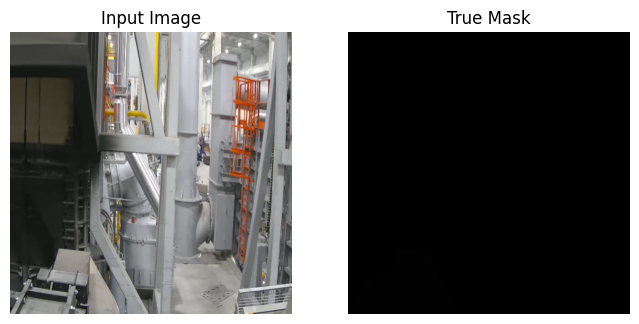

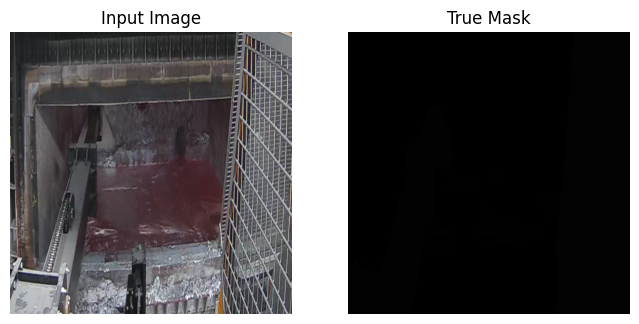

In [ ]:
for images, masks in train_set.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [31]:
lr = 0.00006

In [32]:
model = deepvision.models.SegFormerB0(input_shape=(512, 512, 3),
                                      num_classes=4,
                                      softmax_output=False,
                                      backend='tensorflow')

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer,
              loss=DiceLoss(),
              metrics=[DiceScore()])

In [33]:
model.summary()

Model: "private___seg_former_tf_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 mit_b0_backbone (__MiTTF)      [(None, 128, 128, 3  3319392     ['input_8[0][0]']                
                                2),                                                               
                                 (None, 64, 64, 64)                                               
                                , (None, 32, 32, 16                                               
                                0),                                       

In [34]:
# VAL_SUBSPLITS = 5
# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_set,
                          epochs=15,
                          validation_data=test_set
                          )

Epoch 1/15
131/131 [==============================] - 125s 566ms/step - loss: -2.5868 - dice_score: 3.5868 - val_loss: -6.0721 - val_dice_score: 7.0136
Epoch 2/15
131/131 [==============================] - 73s 554ms/step - loss: -5.9092 - dice_score: 6.9092 - val_loss: -5.9557 - val_dice_score: 6.9237
Epoch 3/15
131/131 [==============================] - 76s 576ms/step - loss: -8.3862 - dice_score: 9.3862 - val_loss: -7.8470 - val_dice_score: 8.7811
Epoch 4/15
 15/131 [==>...........................] - ETA: 59s - loss: -9.7352 - dice_score: 10.7352

KeyboardInterrupt: ignored

In [ ]:
train_set

<BatchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [ ]:
import numpy as np
for i in train_set:
  print(i[0].shape)
  break

(1, 512, 512, 3)


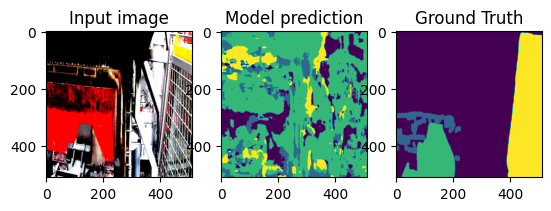

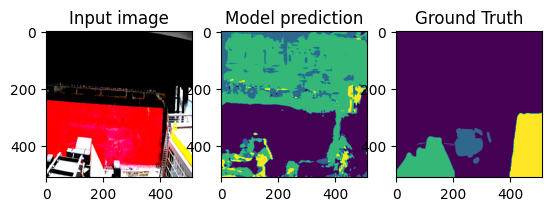

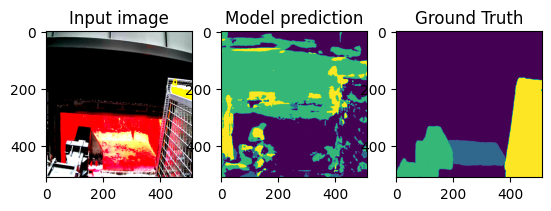

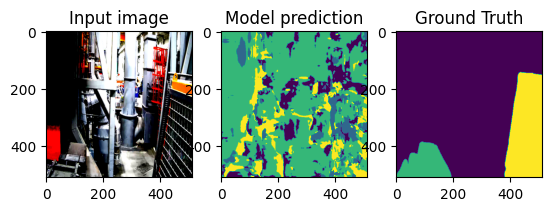

In [ ]:
for images, masks in train_set.take(1):
  inputs, targets = images, masks
  outs = model(inputs)
  outs = tf.argmax(outs, -1)

  for inp, out, target in zip(inputs, outs, targets):
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(inp.numpy())
      ax[1].imshow(out.numpy())
      ax[2].imshow(target.numpy())

      ax[0].set_title('Input image')
      ax[1].set_title('Model prediction')
      ax[2].set_title('Ground Truth')

In [ ]:
for i in train_set:
  print(i[0])
  break